Plan is to create ASCII like art, using the benefits that a typewriter offers, but being aware of it's limitations. Namely, we can overlay characters to multiply the # of glyphs But, we have limited options to begin with, ie. no |@#

Process:
- Input image, desired output size, and directory of glyph images
    - Sub-division of letter spaces, as well as # glyphs per space
- Image is converted to greyscale, and scaled to output size
- Preprocess glyphs, making greyscale & scaled to sub-division
    - I THINK that scaling to eg 3x3 would be the same as doing manual averages
        - !Want to check this!
        - Current theory is this is what BOX resampling would achieve for us
    - If >1 glyph per space, calculate composite glyphs (This scales scarily)
- From the image, take blocks of pixels, the 'target'
    - Iterate through all the glyphs, working out 'distance' from target
        - Don't forget the black space 'glyph'
        - Distance metric likely to be N dimensional pythagorean distance (RMS)
    - Closest glyph gets chosen, repeat for all targets
- Render preview of design, using the original glyph images
    - Monospace REALLY helps with this (25 x 48)
- Produce instruction set to replicate on the typewriter
    - Developing a nice notation here will be useful to do

CURRENT PROBLEMS

- Currently treating glyphs as if they were square, need to adjust this so that the image doesn't end up being stretched vertically
    - Could treat the glyphs (25x48) as 1x2 in scale
    - This is a good approximation, but would be hardcoded
    - One option would just be to prestretch the image the other way

- Currently we're scaling image to full range of our glyphs.
    - This fixes the issues related to have thin glyphs on small SAMPLE_X values
    - However, for higher SAMPLE_X, we can end up making the image darker?
    - Contrast vs Brightness (Perhaps a ranking system rather than Euc distance?)
    
- Image may look MUCH better, if shifted by 1 sample width
    - May want to iterate over, shifting the image, and summing the distances
    - This'd give us a metric of 'best match'
    - Test case would be an image made from glyphs, but shifted a little
        - off anything other than exactly a # of sample widths wouldn't help though
        - Can't check for each and every pixel offset


- Old fill_range was broken, fixed that
    - new fill range produces even more junky images
    - Before, was clipping a lot of lighter colors to 255
    - Now only lightest goes to 255, makes everything bleh
    
    - old was lambda val: ((val-min_) * (t_max/max_))+ t_min

In [92]:
import os
from PIL import Image, ImageChops, ImageOps
from itertools import combinations
import numpy as np
import time

GLYPH_DIR = 'E:/Users/Richard/Documents/One off mini projects/Typewriting/Typearter/Glyphs'
SAMPLE_X = 3  # 3x3 taken from the source glyph
SAMPLE_Y = 3
TARGET_WIDTH = 60
TARGET_HEIGHT = 60  # This and width will come from image dimensions, or will affect that through cropping

def fill_range(image, range_):
    # Scales image colors to fill range_
    # May not be fully warrented hard to say
    min_, max_ = image.getextrema()
    t_min, t_max = range_
    range_ = max_ - min_
    t_range = t_max - t_min
    image =  image.point(lambda val: ((val-min_)* (t_range/range_))+t_min)
    return image

def mean_square_distance(candidate, target):
    # calculates mean Square distance from 2 sequences
    assert len(candidate) == len(target)  # sanity
    squares = [(cand-targ)**2 for cand, targ in zip(candidate, target)]
    return sum(squares)/len(squares)

class glyph:
    def __init__(self, name=None, image=None):
        self.name = name
        self.image = image
        self.fingerprint = self.image.convert("L")\
        .resize((SAMPLE_X, SAMPLE_Y), Image.BOX)
        self.fingerdisplay = self.fingerprint.resize(self.image.size)
        
    @classmethod
    def from_file(cls, filename):
        name = os.path.splitext(filename)[0]
        image = Image.open(os.path.join(GLYPH_DIR, filename))
        return cls(name, image)
    
    def __add__(self, other):
        if not isinstance(other, glyph):
            raise TypeError('can only combine glyph (not "{}") with glyph'.format(type(other)))
        name = self.name + '&' + other.name
        composite = ImageChops.darker(self.image, other.image)
        return glyph(name, composite) 
    
    def __str__(self):
        return self.name

def chunk(list_, width, chunk_width, chunk_height):
    # Given an sequence, width, a chunk width, and chunk height
    # Will return a list of 'chunks' of length chunk width * chunk height
    # [0,1,2,3,4,5,6,7,8,9,A,B,C,D,E,F], 4, 2, 2
    # 0 1 2 3
    # 4 5 6 7
    # 8 9 A B
    # C D E F
    # Would chunk to:
    # [[0,1,4,5], [2,3,6,7], [8,9,C,D], [A,B,E,F]]
    chunks = []
    height = len(list_) // (width*chunk_height*chunk_width)
    for y in range(height):
        rows = range(chunk_height*y, chunk_height*(y+1))
        for x in range(width):
            columns = range(chunk_width*x, chunk_width*(x+1))
            chunk = [list_[column + row*width*chunk_width]\
                     for row in rows for column in columns]
            chunks.append(chunk)
    return chunks

# Using a brute force search.
# If Sample_x = Sample_y, we have 9 dimensions nearest neighbour
# In that regime, an approach like scipy.spatial.cKDTreemay be more performant
def find_closest_glyph(target):
    best = None
    best_distance = float('inf')
    for glyph_name, glyph_ in glyphs.items():
        distance = mean_square_distance(glyph_.fingerprint.getdata(), target)
        if distance < best_distance:
            best_distance = distance
            best = glyph_
    return best

start = time.time()

glyphs = {}
darkest_value = 255
lightest_value = 0
for filename in os.listdir(GLYPH_DIR):
    if filename.endswith(".png"):
        glyph_ = glyph.from_file(filename)
        
        # Little block here testing removing the averagly lightest + darkest
#         vals = list(glyph_.fingerprint.getdata())
#         average_val = sum(vals)//len(vals)
#         if average_val < 200 or average_val > 223:
#             continue
        
        glyphs.update({glyph_.name: glyph_})
        dark, light = glyph_.fingerprint.getextrema()

        darkest_value = min(dark, darkest_value)
        lightest_value = max(light, lightest_value)    

# combination_glyphs = combinations(iter(glyphs.values()), 2)
# for first, second in combination_glyphs:
#     combination = first + second
#     glyphs.update({combination.name:combination})
    
blank = Image.new("L", (25,48), 'white')
space = glyph(name='space', image=blank)
glyphs.update({'space':space})

# lightest_value = 255  # need to unhardcode

TARGET_IMAGE = 'E:/Users/Richard/Documents/One off mini projects/Typewriting/Typearter/dog.png'
dog = Image.open(TARGET_IMAGE)

dog.show()

desired_aspect = 25/48  # unhardcode

# Corrects image aspect ratio, centered on image
current_aspect = dog.width/dog.height
if current_aspect < desired_aspect:
    # Too tall image
    perfect_height = dog.width / desired_aspect
    edge = (dog.height - perfect_height) /2
    dog = dog.crop((0, edge, dog.width, perfect_height+edge))
else:
    # Too wide image
    perfect_width = dog.height * desired_aspect
    edge = (dog.width - perfect_width) /2
    dog = dog.crop((edge, 0, perfect_width+edge, dog.height))

dog.show()

# Changing the resampling mode here changes how the image ends up
smol_dog = dog.resize((TARGET_WIDTH * SAMPLE_X, TARGET_HEIGHT * SAMPLE_Y), Image.LANCZOS)
smol_dog = smol_dog.convert("L")

# Some ImageOps may help with color reproduction
smol_dog = ImageOps.autocontrast(smol_dog, cutoff=0)
#smol_dog = ImageOps.equalize(smol_dog)
smol_dog = fill_range(smol_dog, (darkest_value, lightest_value))

target_parts = chunk(list(smol_dog.getdata()), width=TARGET_WIDTH,
                     chunk_width=SAMPLE_X, chunk_height=SAMPLE_Y)

result = []

for section in target_parts:   
    result.append(find_closest_glyph(section))
    
calculation = Image.new("L", (TARGET_WIDTH * 25, TARGET_HEIGHT * 48))
output = Image.new("L", (TARGET_WIDTH * 25, TARGET_HEIGHT  * 48))

for i, glyph_ in enumerate(result):
    w = 25
    h = 48
    x = w * (i % TARGET_WIDTH)
    y = h * (i // TARGET_WIDTH)
    calculation.paste(glyph_.fingerdisplay, (x, y, x + w, y + h))
    output.paste(glyph_.image, (x, y, x + w, y + h))

calculation.show()
output.show()

end = time.time()
print(end-start)

6.97523307800293


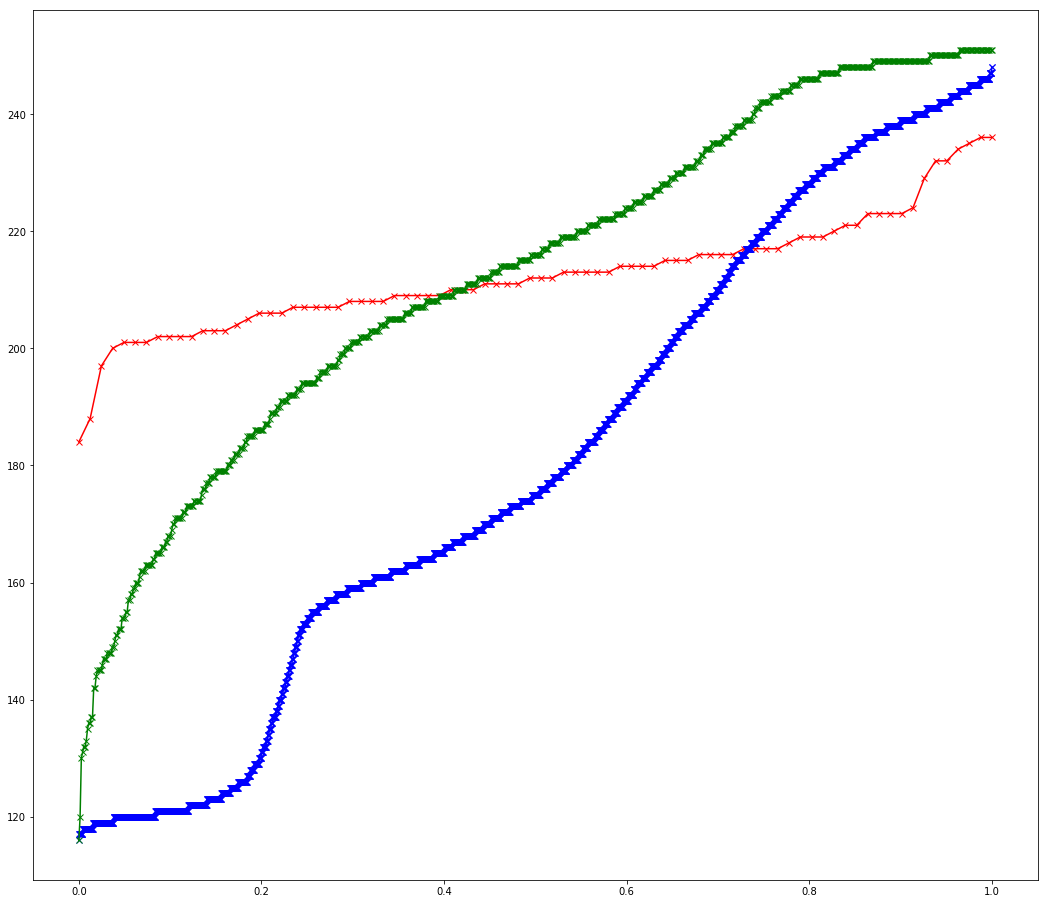

In [74]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

average_vals = []
sub_values = []
for i, glyph_ in glyphs.items():
    vals = list(glyph_.fingerprint.getdata())
    average_val = sum(vals)//len(vals)
#     print(glyph_.name + ': '+str(average_val))
    average_vals.append(average_val)
    sub_values.extend(vals)
    
section_vals = []
    
for section in target_parts:
    average = sum(section)//len(section)
    section_vals.append(average)
    
fig1 = plt.figure(figsize=(18,16))
l, = plt.plot(np.linspace(0, 1, len(average_vals)), sorted(average_vals), 'rx-')
l, = plt.plot(np.linspace(0, 1, len(section_vals)), sorted(section_vals), 'bx-')
l, = plt.plot(np.linspace(0, 1, len(sub_values)), sorted(sub_values), 'gx-')

colon&hyphen


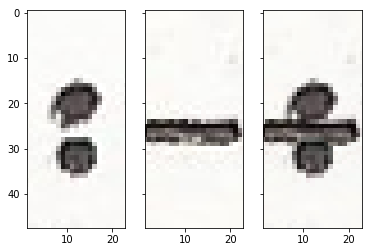

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(1,3, sharey=True)

colon = glyphs['colon']
hyphen = glyphs['hyphen']
obelus = colon + hyphen

print(obelus.name)

axarr[0].imshow(colon.image)
axarr[1].imshow(hyphen.image)
axarr[2].imshow(obelus.image)

In [99]:
# PLAYING WITH ENHANCEMENTS, TRYING TO MATCH OLD 'LOOK'

from PIL import ImageEnhance

testdog = dog.convert("L")

#testdog.show()
t_min = darkest_value
t_max = lightest_value
min_, max_ = testdog.getextrema()
range_ = max_ - min_
t_range = t_max - t_min
old_dog = testdog.point(lambda val: ((val-min_) * (t_max/max_))+ t_min)
new_dog =  testdog.point(lambda val: ((val-min_)* (t_range/range_))+t_min)

contrast = ImageEnhance.Contrast(new_dog)
e_dog = contrast.enhance(2.5)
brightness = ImageEnhance.Brightness(e_dog)
b_dog = brightness.enhance(1.5)


old_dog.show()
new_dog.show()
b_dog.show()

In [97]:
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import random
from PIL import Image
import time

random_sections = []

tree_answers = []
brute_answers = []

range_ = lightest_value - darkest_value
for i in range(100000):
    random_sections.append([int(random.random()*range_)+darkest_value for i in range(len(glyph_data[0]))])

start_brute = time.time()
    
for section in random_sections:
    brute_answers.append(find_closest_glyph(section))
    
end_brute = time.time()
start_tree = time.time()

glyph_list = list(glyphs.values())
glyph_data = [list(glyph.fingerprint.getdata()) for glyph in glyph_list]
tree = cKDTree(glyph_data)

def find_closest_glyph_tree(section):
    dd, ii = tree.query(section)
    return glyph_list[ii]

for section in random_sections:
    tree_answers.append(find_closest_glyph_tree(section))

end_tree = time.time()
    
# rand_image = Image.fromarray(np.array(rand).reshape(3,3))\
#                     .resize(match.fingerdisplay.size)

# f, axarr = plt.subplots(1,3, sharey=True)

# match_finger = match.fingerdisplay.convert("RGB")
# match_image = match.image

# axarr[0].imshow(rand_image)
# axarr[1].imshow(match_finger)
# axarr[2].imshow(match_image)

print('Brute-force took {}s'.format(end_brute - start_brute))
print('Tree lookup took {}s'.format(end_tree - start_tree))


Brute-force took 46.05757474899292s
Tree lookup took 4.914031982421875s
